In [23]:
from main import get_last_data_path
import pickle
from consts import GEMMA_2
from analysis import ComponentAnalyzer
import numpy as np
from typing import List, Tuple

data_dir = "data"

data_path = get_last_data_path(data_dir)
with open(data_path, "rb") as f:
    data = pickle.load(f)

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
gemma_2_data = data[GEMMA_2]
position = -1

print(len(gemma_2_data.keys()))

25


In [26]:
def sort_by_path_appearance(coefs: np.ndarray, feature_names: List[str]) -> List[Tuple[str, float]]:
    entry_order_indices = np.argmax(np.abs(coefs) > 0, axis=1)

    active_features_mask = np.any(np.abs(coefs) > 0, axis=1)
    active_feature_indices = np.where(active_features_mask)[0]

    # Map the entry order to the active features
    active_entry_order = entry_order_indices[active_feature_indices]

    # Sort the active features by their entry order
    final_sorted_indices = active_feature_indices[np.argsort(active_entry_order)]

    ordered_feature_names = [feature_names[i] for i in final_sorted_indices]

    return ordered_feature_names

In [27]:
import re

def component_to_layer_num(component_name: str) -> int:
    re_pattern = 'blocks\.(\d+)\.*'
    layer_num = re.search(re_pattern, component_name).group(1)
    layer_num = int(layer_num)
    return layer_num


In [28]:
# from collections import defaultdict
# r2_dict = defaultdict(list)
# diff_in_r2_dict = defaultdict(list)

# k = 4
# num_layers = 21
# mlp_top_k_frequencies = {"positive": [0 for _ in range(num_layers)], "negative": [0 for _ in range(num_layers)]}
# attn_top_k_frequencies = {"positive": [0 for _ in range(num_layers)], "negative": [0 for _ in range(num_layers)]}
# for steering_vector, per_vector_data in gemma_2_data.items():
#     data_at_position = per_vector_data['all']

#     negative_outputs_train, positive_outputs_train, negative_outputs_test, positive_outputs_test = data_at_position
#     negative_dots_train = negative_outputs_train[0]
#     positive_dots_train = positive_outputs_train[0]
#     negative_dots_test = negative_outputs_test[0]
#     positive_dots_test = positive_outputs_test[0]


#     analyzer = ComponentAnalyzer(
#                 model_name=GEMMA_2,
#                 steering_vector=steering_vector,
#                 data=per_vector_data,
#                 multicomponent=False,
#                 results_dir=None,
#                 quiet=True,
#                 save_details=False,
#             )

#     mlp_r2_positive, attn_r2_positive, coefs_mlp_positive, coefs_attn_positive, mlp_names, attn_names = analyzer.predictor.mlp_vs_attn(
#         positive_dots_train,
#         positive_dots_test
#     )

#     diff_in_r2_dict['diff'].append(mlp_r2_positive - attn_r2_positive)
#     diff_in_r2_dict['set'].append('positive')

#     r2_dict['component'].extend(['mlp', 'attn'])
#     r2_dict['r2'].extend([mlp_r2_positive, attn_r2_positive])
#     r2_dict['set'].extend(['positive', 'positive'])

#     mlp_names = [component_to_layer_num(c) for c in mlp_names]
#     attn_names = [component_to_layer_num(c) for c in attn_names]

#     positive_mlp_features = sort_by_path_appearance(coefs_mlp_positive, mlp_names)
#     positive_attn_features = sort_by_path_appearance(coefs_attn_positive, attn_names)

#     for layer_index in range(k):
#         mlp_top_k_frequencies["positive"][positive_mlp_features[layer_index]] += 1
#         attn_top_k_frequencies["positive"][positive_attn_features[layer_index]] += 1

#     mlp_r2_negative, attn_r2_negative, coefs_mlp_negative, coefs_attn_negative, ignore_mlp_names, ignore_attn_names = analyzer.predictor.mlp_vs_attn(
#         negative_dots_train,
#         negative_dots_test
#     )

#     diff_in_r2_dict['diff'].append(attn_r2_negative - mlp_r2_negative)
#     diff_in_r2_dict['set'].append('negative')

#     r2_dict['component'].extend(['mlp', 'attn'])
#     r2_dict['r2'].extend([mlp_r2_negative, attn_r2_negative])
#     r2_dict['set'].extend(['negative', 'negative'])

#     negative_mlp_features = sort_by_path_appearance(coefs_mlp_negative, mlp_names)
#     negative_attn_features = sort_by_path_appearance(coefs_attn_negative, attn_names)

#     for layer_index in range(k):
#         mlp_top_k_frequencies["negative"][negative_mlp_features[layer_index]] += 1
#         attn_top_k_frequencies["negative"][negative_attn_features[layer_index]] += 1
    


In [29]:
from collections import defaultdict
num_layers = 21
def get_frequencies_for_k(k):
    r2_dict = defaultdict(list)
    diff_in_r2_dict = defaultdict(list)

    positive_top_k_frequencies = {"MLP": [0 for _ in range(num_layers)], "ATTN": [0 for _ in range(num_layers)]}
    negative_top_k_frequencies = {"MLP": [0 for _ in range(num_layers)], "ATTN": [0 for _ in range(num_layers)]}
    for steering_vector, per_vector_data in gemma_2_data.items():
        data_at_position = per_vector_data['all']

        negative_outputs_train, positive_outputs_train, negative_outputs_test, positive_outputs_test = data_at_position
        negative_dots_train = negative_outputs_train[0]
        positive_dots_train = positive_outputs_train[0]
        negative_dots_test = negative_outputs_test[0]
        positive_dots_test = positive_outputs_test[0]

        analyzer = ComponentAnalyzer(
                    model_name=GEMMA_2,
                    steering_vector=steering_vector,
                    data=per_vector_data,
                    multicomponent=False,
                    results_dir=None,
                    quiet=True,
                    save_details=False,
                )

        r2_positive, coefs_positive, alphas_positive, feature_names_positive = analyzer.predictor.ranking_components(
            positive_dots_train,
            positive_dots_test
        )

        positive_features = sort_by_path_appearance(coefs_positive, feature_names_positive)

        for layer_index in range(k):
            feature_name = positive_features[layer_index]
            if 'mlp' in feature_name or 'ln2' in feature_name:
                positive_top_k_frequencies["MLP"][component_to_layer_num(feature_name)] += 1
            elif 'attn' in feature_name or 'ln1' in feature_name:
                positive_top_k_frequencies["ATTN"][component_to_layer_num(feature_name)] += 1

        r2_negative, coefs_negative, alphas_negative, feature_names_negative = analyzer.predictor.ranking_components(
            negative_dots_train,
            negative_dots_test
        )

        negative_features = sort_by_path_appearance(coefs_negative, feature_names_negative)

        for layer_index in range(k):
            feature_name = negative_features[layer_index]
            if 'mlp' in feature_name or 'ln2' in feature_name:
                negative_top_k_frequencies["MLP"][component_to_layer_num(feature_name)] += 1
            elif 'attn' in feature_name or 'ln1' in feature_name:
                negative_top_k_frequencies["ATTN"][component_to_layer_num(feature_name)] += 1

    return positive_top_k_frequencies, negative_top_k_frequencies

In [30]:
import json

frequencies_dict = {f'k={i}': get_frequencies_for_k(i) for i in [1,10,15]}
json.dump(frequencies_dict, open('frequencies_dict.json', 'w'))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def create_radar_plot(df, title):
    """
    Generates a radar plot from a pandas DataFrame.

    Args:
        df (pd.DataFrame): DataFrame where the index represents the categories (labels)
                           and each column is a different data series to plot.
        title (str): The title for the plot.
    """
    # Get the categories (e.g., layers 0, 1, 2, ...) from the DataFrame index
    categories = df.index.tolist()
    num_categories = len(categories)

    # Calculate the angle for each category
    # The plot is circular, so we divide 2*pi by the number of categories
    angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
    # To close the plot, we need to repeat the first angle at the end
    angles += angles[:1]

    # Initialize the plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # --- Plotting each data series ---
    colors = ['#e63946', '#00ffff', '#2a9d8f'] # Red, Cyan, Green
    
    for i, column in enumerate(df.columns):
        # Get the values for the current series
        values = df[column].tolist()
        # To close the plot, repeat the first value at the end
        values += values[:1]

        # Plot the line
        ax.plot(angles, values, color=colors[i], linewidth=2, label=column)
        # Fill the area under the line
        ax.fill(angles, values, color=colors[i], alpha=0.2)

    # --- Customizing the plot ---
    
    # Set the labels for each category
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)

    # Set the radial axis labels (the concentric circles)
    ax.set_rlabel_position(0) # Position the labels
    plt.yticks([2, 4, 6, 8, 10], ["2", "4", "6", "8", "10"], color="grey", size=10)
    plt.ylim(0, 11)

    # Add plot title and legend
    plt.title(title, size=14, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    
    # Display the plot
    plt.show()

attention_data = {
    'k=1': [6, 6.2, 5.8, 3, 2, 1, 6.5, 7, 1.5, 2.5, 9, 10, 5, 3, 2, 4, 8, 5, 2, 1.5, 1],
    'k=10': [5.5, 6, 5.5, 3.5, 2.5, 1.5, 6, 6.5, 2, 3, 8.5, 9.5, 5.5, 3.5, 2.5, 4.5, 7.5, 5.5, 2.5, 2, 1.5],
    'k=15': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

# The labels for the axes (0 to 20 layers)
layers = list(range(21))

# Create the pandas DataFrame
df_attention = pd.DataFrame(attention_data, index=layers)

# 2. GENERATE THE PLOT
create_radar_plot(df_attention, 'Attention (Positive set)')

# You could create another DataFrame for the MLP data and call the function again
# For example:
# df_mlp = pd.read_csv('your_mlp_data.csv', index_col=0)
# create_radar_plot(df_mlp, 'MLP (Positive set)')


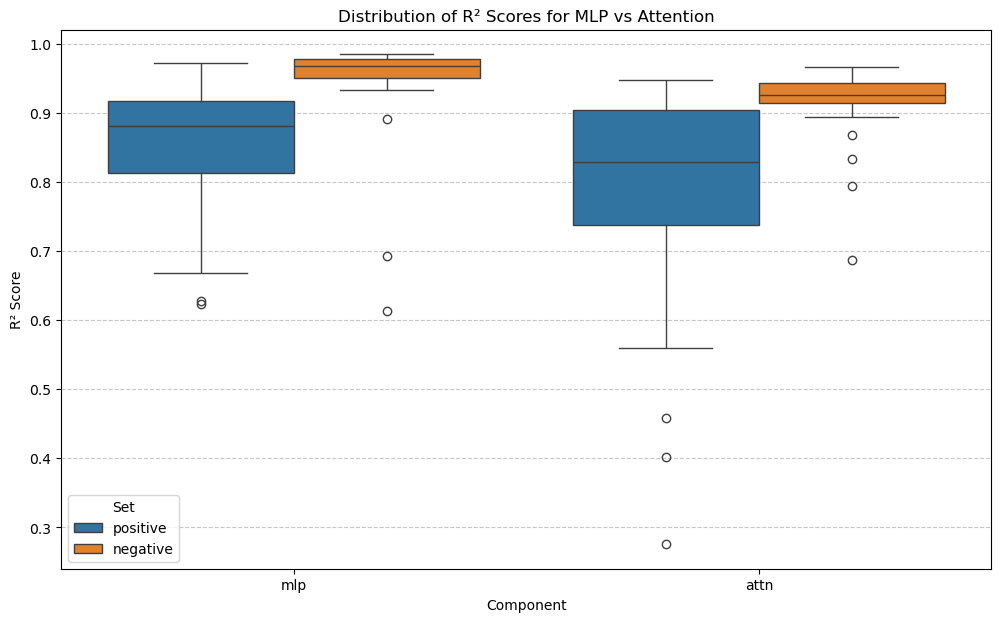

In [ ]:
r2_df = pd.DataFrame(r2_dict)

plt.figure(figsize=(12, 7))
sns.boxplot(
    data=r2_df,
    x='component',
    y='r2',
    hue='set',
)

plt.title('Distribution of R² Scores for MLP vs Attention')
plt.xlabel('Component')
plt.ylabel('R² Score')
plt.legend(title='Set')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig('r2_distribution.png')
plt.show()

In [13]:
sum(positive_top_k_frequencies['MLP']), sum(positive_top_k_frequencies['ATTN'])

(41, 34)

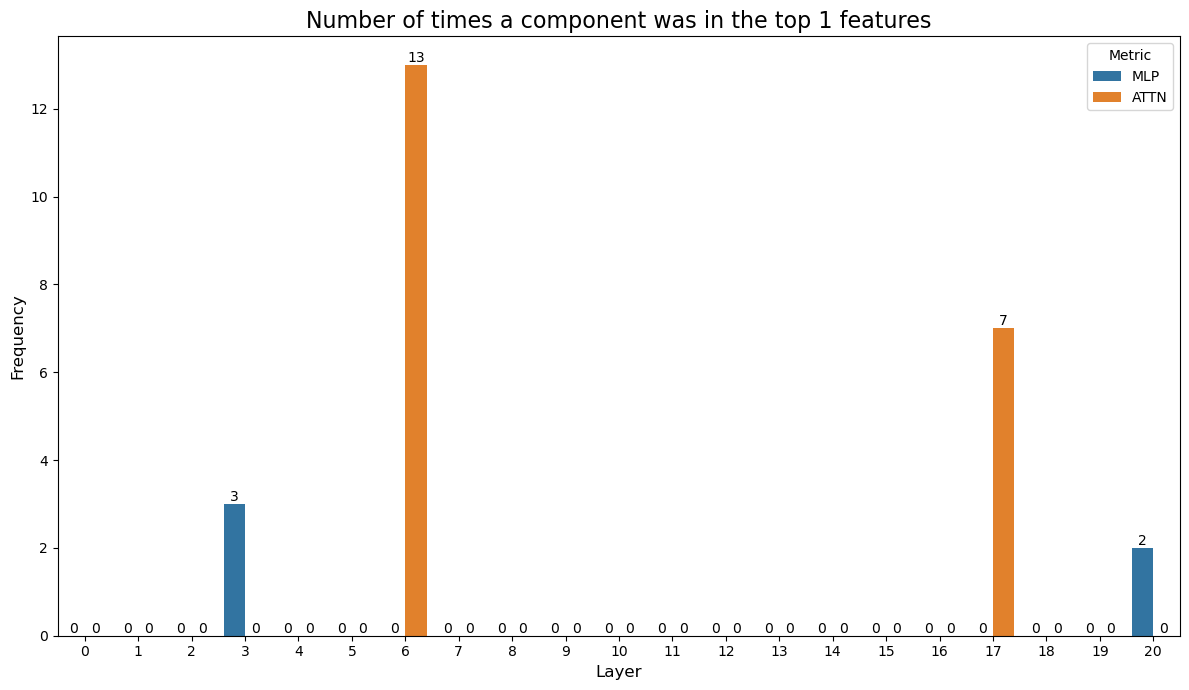

In [21]:
positive_top_k_frequencies_df = pd.DataFrame(positive_top_k_frequencies)

df_long = positive_top_k_frequencies_df.reset_index().melt(
    id_vars=['index'],
    var_name='Metric',
    value_name='Value'
)

plt.figure(figsize=(12, 7))
barplot = sns.barplot(x='index', y='Value', hue='Metric', data=df_long)

plt.title(f'Number of times a component was in the top {k} features', fontsize=16)
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

for container in barplot.containers:
    barplot.bar_label(container)

plt.tight_layout()
plt.savefig(f'positive_top_{k}_frequencies.pdf')
plt.show()


In [15]:
sum(negative_top_k_frequencies['MLP']), sum(negative_top_k_frequencies['ATTN'])

(38, 37)

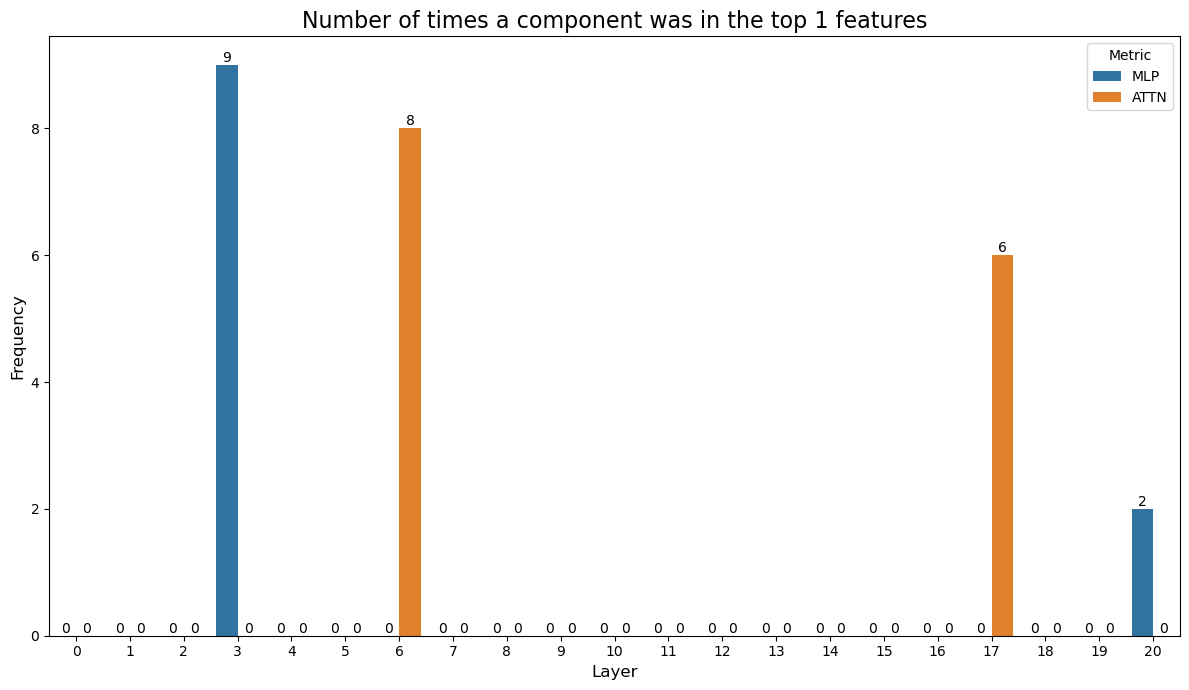

In [22]:
negative_top_k_frequencies_df = pd.DataFrame(negative_top_k_frequencies)

df_long = negative_top_k_frequencies_df.reset_index().melt(
    id_vars=['index'],
    var_name='Metric',
    value_name='Value'
)

plt.figure(figsize=(12, 7))
barplot = sns.barplot(x='index', y='Value', hue='Metric', data=df_long)

plt.title(f'Number of times a component was in the top {k} features', fontsize=16)
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

for container in barplot.containers:
    barplot.bar_label(container)

plt.tight_layout()
plt.savefig(f'negative_top_{k}_frequencies.pdf')
plt.show()


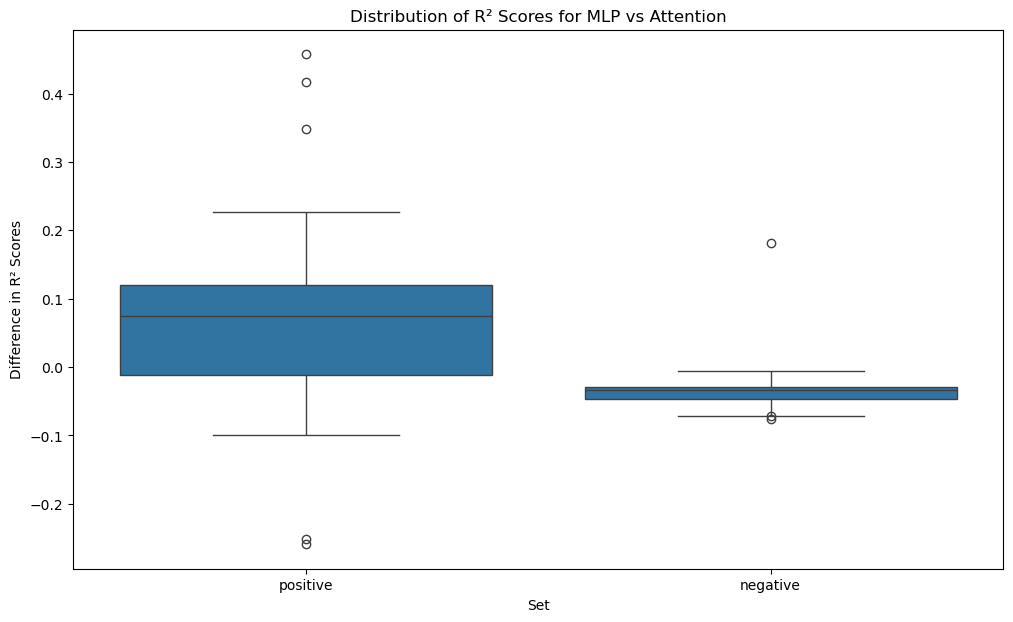

In [22]:
diff_in_r2_df = pd.DataFrame(diff_in_r2_dict)

plt.figure(figsize=(12, 7))
sns.boxplot(
    data=diff_in_r2_df,
    x='set',
    y='diff',
)

plt.title('Distribution of R² Scores for MLP vs Attention')
plt.xlabel('Set')
plt.ylabel('Difference in R² Scores')
plt.savefig('diff_in_r2_distribution.png')
plt.show()

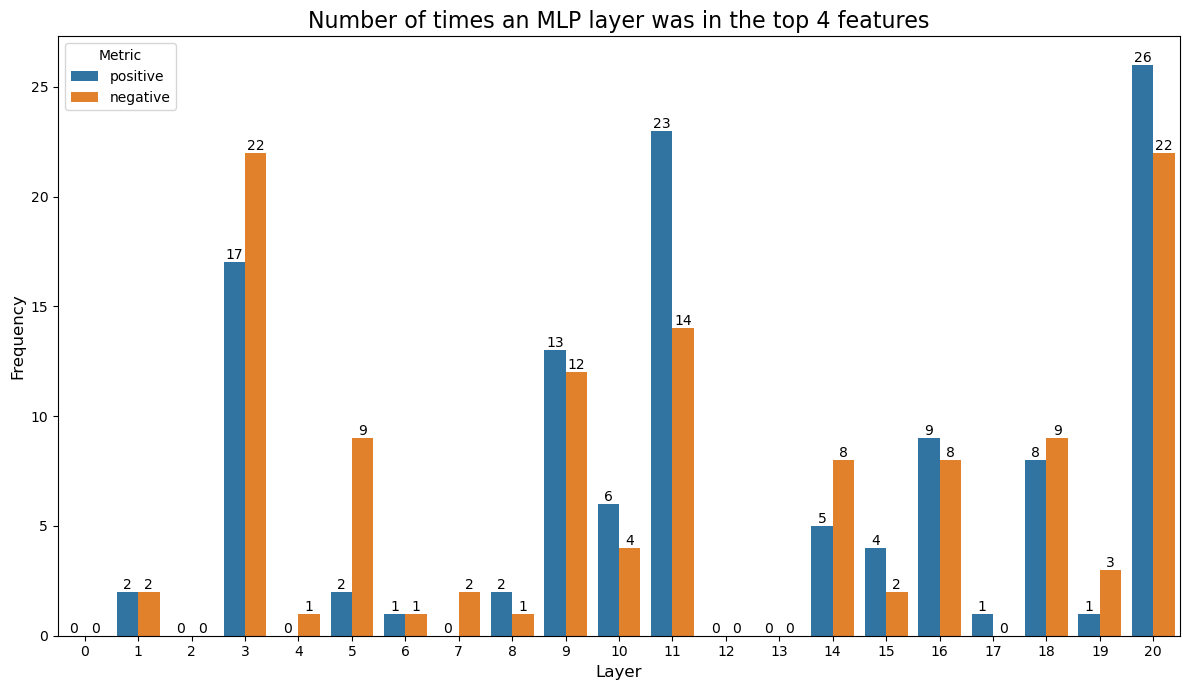

In [23]:
mlp_top_k_frequencies_df = pd.DataFrame(mlp_top_k_frequencies)


df_long = mlp_top_k_frequencies_df.reset_index().melt(
    id_vars=['index'],
    var_name='Metric',
    value_name='Value'
)

plt.figure(figsize=(12, 7))
barplot = sns.barplot(x='index', y='Value', hue='Metric', data=df_long)

plt.title(f'Number of times an MLP layer was in the top {k} features', fontsize=16)
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

for container in barplot.containers:
    barplot.bar_label(container)

plt.tight_layout()
plt.savefig(f'mlp_top_{k}_frequencies.png')
plt.show()


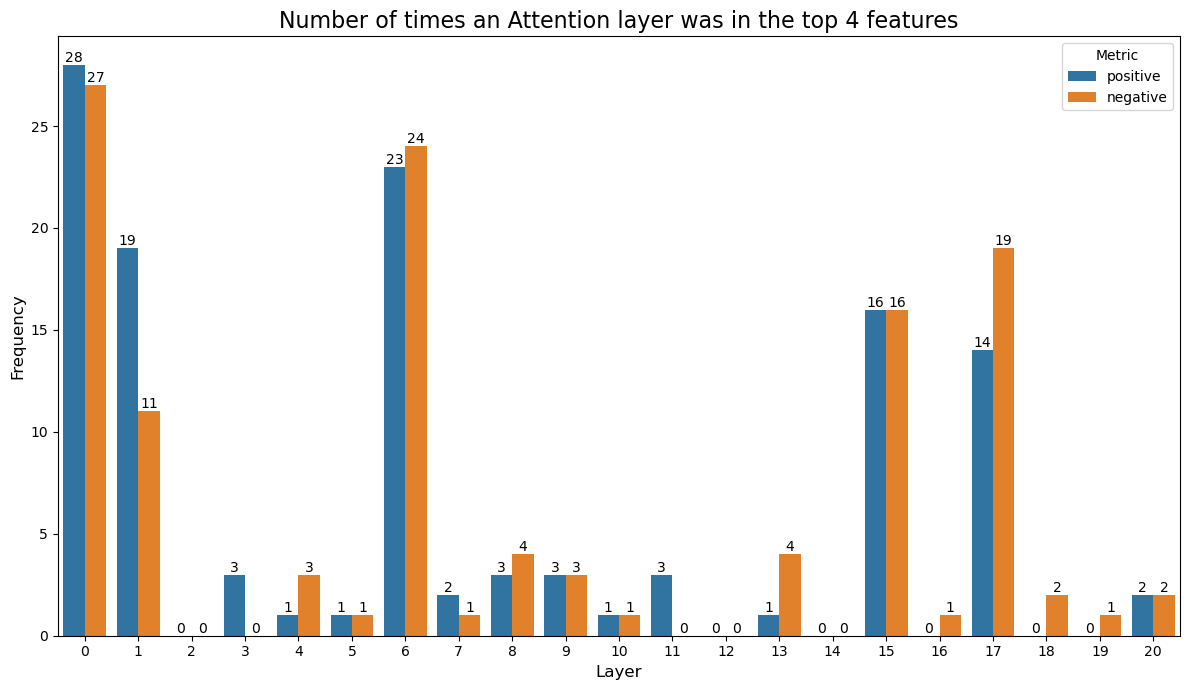

In [24]:
attn_top_k_frequencies_df = pd.DataFrame(attn_top_k_frequencies)


df_long = attn_top_k_frequencies_df.reset_index().melt(
    id_vars=['index'],
    var_name='Metric',
    value_name='Value'
)

plt.figure(figsize=(12, 7))
barplot = sns.barplot(x='index', y='Value', hue='Metric', data=df_long)

plt.title(f'Number of times an Attention layer was in the top {k} features', fontsize=16)
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

for container in barplot.containers:
    barplot.bar_label(container)

plt.tight_layout()
plt.savefig(f'attn_top_{k}_frequencies.png')
plt.show()